<center><h2>Testing the Functionality of the <i>"utils.py"</i> Module</h2></center>

In [1]:
""" Tetsing the following functionality: 
    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)
    * alignment (kabsch)ç
    * 3d coords (mds)
    -----
    The data files used contain the id of the original
    crystal structures from the RCSB PDB
"""

' Tetsing the following functionality: \n    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)\n    * alignment (kabsch)ç\n    * 3d coords (mds)\n    -----\n    The data files used contain the id of the original\n    crystal structures from the RCSB PDB\n'

In [1]:
import os
import sys
# science
import numpy as np
import torch
import matplotlib.pyplot as plt
# molecular utils
import mdtraj
# functionality
sys.path.append("../")
from utils import *

In [2]:
# load pdb file
prot = mdtraj.load_pdb("data/1h22_protein.pdb").xyz[0].transpose()

## Metrics

In [3]:
# alter a small amount and measure metrics
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1

In [4]:
# Numpy
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

# Torch
prot, pred = torch.tensor(prot), torch.tensor(pred)
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [0.5765397]
gdt_ha is:  [0.64635264]
gdt_ts is:  [0.8803458]
tm_score is:  [0.99814738]
rmsd is:  tensor([0.5765], dtype=torch.float64)
gdt_ha is:  tensor([0.6464])
gdt_ts is:  tensor([0.8803])
tm_score is:  tensor([0.9981], dtype=torch.float64)


## Alignment

In [5]:
prot = prot.cpu().numpy()
pred = pred.cpu().numpy()

In [6]:
# rotation matrix
R = np.array([[0.25581, -0.77351, 0.57986],
              [-0.85333, -0.46255, -0.24057],
              [0.45429, -0.43327, -0.77839]])

In [7]:
# perturb protein (translation + rotation + random)
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1 
pred = np.dot(R, pred)

In [8]:
# check realignment works - torch
pred_mod_, prot_mod_ = Kabsch(torch.tensor(pred).double(), torch.tensor(prot).double())
RMSD(prot_mod_, pred_mod_), TMscore(prot_mod_, pred_mod_)

(tensor([0.5752], dtype=torch.float64), tensor([0.9982], dtype=torch.float64))

In [9]:
# check realignment works - torch
pred_mod, prot_mod = Kabsch(pred, prot)
RMSD(prot_mod, pred_mod), TMscore(prot_mod, pred_mod)

(array([0.57522491]), array([0.99815585]))

## 3d Converter

In [10]:
prot_traj = mdtraj.load_pdb("data/1h22_protein.pdb")

In [11]:
prot = prot_traj.xyz[0].transpose()

In [12]:
# works with a simple distance matrix for now
prot = torch.tensor(prot)
distogram = torch.cdist(prot.t(), prot.t())

In [13]:
# plt.imshow(distogram, cmap="viridis_r")

In [14]:
# select indices of backbone for angle calculation and selection
N_mask  = prot_traj.topology.select("name == N and backbone")
CA_mask = prot_traj.topology.select("name == CA and backbone") 
CA_mask.shape, N_mask.shape

((528,), (529,))

In [20]:
pred, stress = MDScaling(distogram, iters=200, tol=1e-5,
                         fix_mirror=3, N_mask=N_mask, CA_mask=CA_mask)

[0, 1, 2]
it: 0, stress tensor(1.4235e+08)
it: 1, stress tensor(70479592.)
it: 2, stress tensor(64633496.)
it: 3, stress tensor(61598372.)
it: 4, stress tensor(60051312.)
it: 5, stress tensor(59241588.)
it: 6, stress tensor(58797864.)
it: 7, stress tensor(58528040.)
it: 8, stress tensor(58334752.)
it: 9, stress tensor(58167564.)
it: 10, stress tensor(57995224.)
it: 11, stress tensor(57794916.)
it: 12, stress tensor(57542480.)
it: 13, stress tensor(57213924.)
it: 14, stress tensor(56780288.)
it: 15, stress tensor(56207876.)
it: 16, stress tensor(55458128.)
it: 17, stress tensor(54489800.)
it: 18, stress tensor(53264780.)
it: 19, stress tensor(51751944.)
it: 20, stress tensor(49938684.)
it: 21, stress tensor(47842032.)
it: 22, stress tensor(45516776.)
it: 23, stress tensor(43045592.)
it: 24, stress tensor(40538344.)
it: 25, stress tensor(38103564.)
it: 26, stress tensor(35831208.)
it: 27, stress tensor(33781952.)
it: 28, stress tensor(31965546.)
it: 29, stress tensor(30383978.)
it: 30, s

it: 56, stress tensor(541518.1875)
it: 57, stress tensor(452872.)
it: 58, stress tensor(376175.2188)
it: 59, stress tensor(310863.7812)
it: 60, stress tensor(256845.8750)
it: 61, stress tensor(212857.8438)
it: 62, stress tensor(176379.0312)
it: 63, stress tensor(145054.8281)
it: 64, stress tensor(117635.3281)
it: 65, stress tensor(93603.6562)
it: 66, stress tensor(72578.3516)
it: 67, stress tensor(54375.6445)
it: 68, stress tensor(39268.5977)
it: 69, stress tensor(27791.6758)
it: 70, stress tensor(19733.7305)
it: 71, stress tensor(14250.8281)
it: 72, stress tensor(10453.1328)
it: 73, stress tensor(7750.4888)
it: 74, stress tensor(5796.1113)
it: 75, stress tensor(4369.4419)
it: 76, stress tensor(3320.5413)
it: 77, stress tensor(2545.1284)
it: 78, stress tensor(1967.3381)
it: 79, stress tensor(1533.1814)
it: 80, stress tensor(1204.3645)
it: 81, stress tensor(953.3463)
it: 82, stress tensor(759.7357)
it: 83, stress tensor(609.3867)
it: 84, stress tensor(491.7586)
it: 85, stress tensor(398

In [21]:
# check realignment works
pred_mod, prot_mod = Kabsch(pred.numpy(), prot.numpy())
# measure
rmsd     = RMSD(prot_mod, pred_mod)
gdt_ha   = GDT(prot_mod, pred_mod, mode="HA")
gdt_ts   = GDT(prot_mod, pred_mod, mode="TS")
tm_score = TMscore(prot_mod, pred_mod)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [3.7103262e-05]
gdt_ha is:  [1.]
gdt_ts is:  [1.]
tm_score is:  [1.]


## See reconstruction

In [22]:
new_distogram = torch.cdist(pred.t(), pred.t())
delta_dist    = new_distogram-distogram

Diffs: max = 0.004259645938873291 and min -0.005857259035110474


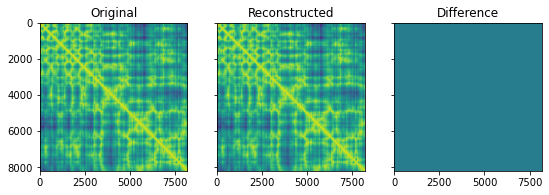

In [23]:
fig, ax = plt.subplots(1,3,figsize=(9, 3), sharey=True)
cmap = plt.get_cmap("viridis_r")

ax[0].set_title("Original")
ax[0].imshow(distogram, cmap="viridis_r")
ax[1].set_title("Reconstructed")
ax[1].imshow(new_distogram, cmap="viridis_r")
ax[2].set_title("Difference")
ax[2].imshow(delta_dist, cmap="viridis_r")


print("Diffs: max = {0} and min {1}".format(np.amax(delta_dist.numpy()),
                                            np.amin(delta_dist.numpy()) ))

In [24]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein.pdb")
buffer_save.xyz = pred_mod.T[None, :, :]
buffer_save.save("data/save_to_check.pdb")

In [25]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein.pdb")
buffer_save.xyz = prot_mod.T[None, :, :]
buffer_save.save("data/save_to_check_base.pdb")

Legend:
* blue/purple: reference
* green/orange: our reconstruction

Comments: only small blue detail on the left. increase match by decreasing tolerance

<img src="data/comparison.png">